In [1]:
pip install --upgrade jinja2
pip install setuptools
pip install nbformat>=4.2.0
pip install scikit-learn
pip install tensorflow

SyntaxError: invalid syntax (2930484285.py, line 2)

In [1]:
# Importations de bibliothèques standard et scientifiques
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px

# Importations de Scikit-Learn (Machine Learning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score, precision_score, accuracy_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Importations de MLflow (suivi des expériences)
import mlflow
from mlflow.tracking import MlflowClient

# Utilitaires divers
from pprint import pprint



In [2]:
# Lire le fichier CSV
df = pd.read_csv('Loan_Data.csv')

# Afficher les premières lignes du dataframe
df.head(4)

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0


In [7]:
#Colonnes à arrondir et nettoyer
columns_to_round = ['loan_amt_outstanding', 'total_debt_outstanding', 'income']

# Arrondir les valeurs et convertir en entiers
for col in columns_to_round:
    df[col] = df[col].round().astype(int)

# Afficher les premières lignes du dataframe nettoyé pour vérification
print(df.head(2))

   customer_id  credit_lines_outstanding  loan_amt_outstanding  \
0      8153374                         0                  5222   
1      7442532                         5                  1959   

   total_debt_outstanding  income  years_employed  fico_score  default  
0                    3915   78039               5         605        0  
1                    8229   26648               2         572        1  


In [8]:
df.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.679400,8718.918400,70039.90230,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.406165,6627.162615,20072.21515,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,47.000000,32.000000,1000.00000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.000000,4200.000000,56540.00000,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.500000,6732.500000,70086.00000,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5053.000000,11272.000000,83429.25000,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10751.000000,43689.000000,148412.00000,10.000000,850.000000,1.000000


In [9]:
df.shape

(10000, 8)

In [10]:
df.dtypes

customer_id                 int64
credit_lines_outstanding    int64
loan_amt_outstanding        int32
total_debt_outstanding      int32
income                      int32
years_employed              int64
fico_score                  int64
default                     int64
dtype: object

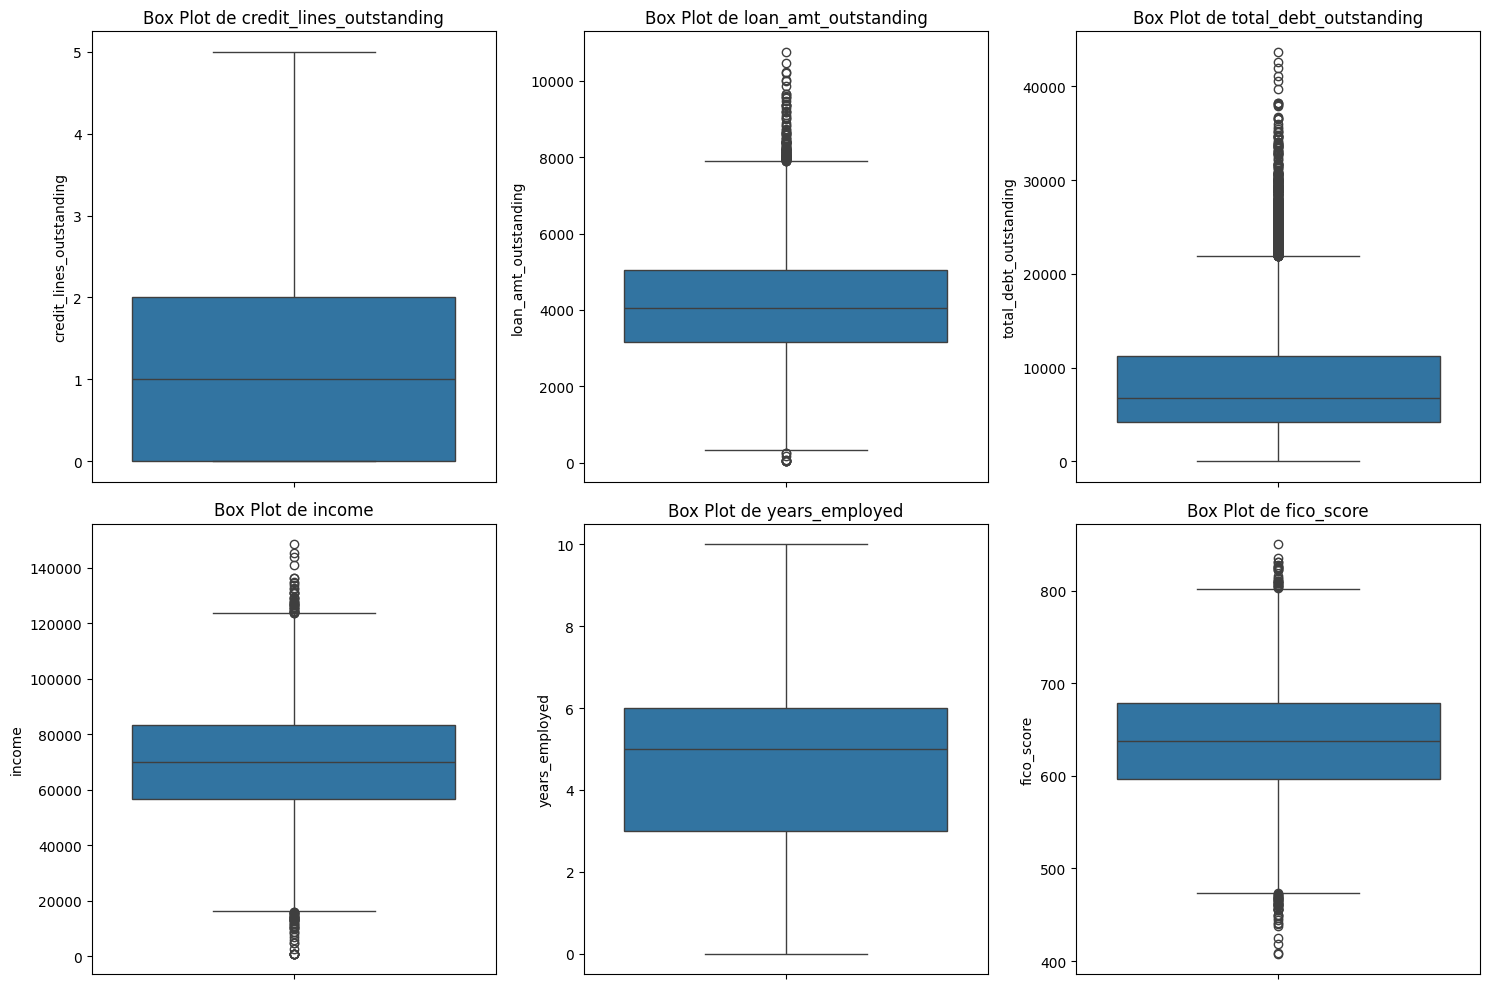

In [11]:
# Sélectionner les colonnes pertinentes pour détecter les outliers
cols = ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score']

# Créer des box plots pour chaque colonne
plt.figure(figsize=(15, 10))

for i, col in enumerate(cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot de {col}')

plt.tight_layout()
plt.show()

In [14]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Utilisation de la fonction
columns_to_clean = ['loan_amt_outstanding', 'total_debt_outstanding', 'income', 'fico_score']
df_cleaned = remove_outliers(df, columns_to_clean)

Aucun outlier détecté pour 'credit_lines_outstanding'.
Première valeur outlier pour 'loan_amt_outstanding': 7757
Première valeur outlier pour 'total_debt_outstanding': 18858
Première valeur outlier pour 'income': 120044
Première valeur outlier pour 'years_employed': 0
Première valeur outlier pour 'fico_score': 480


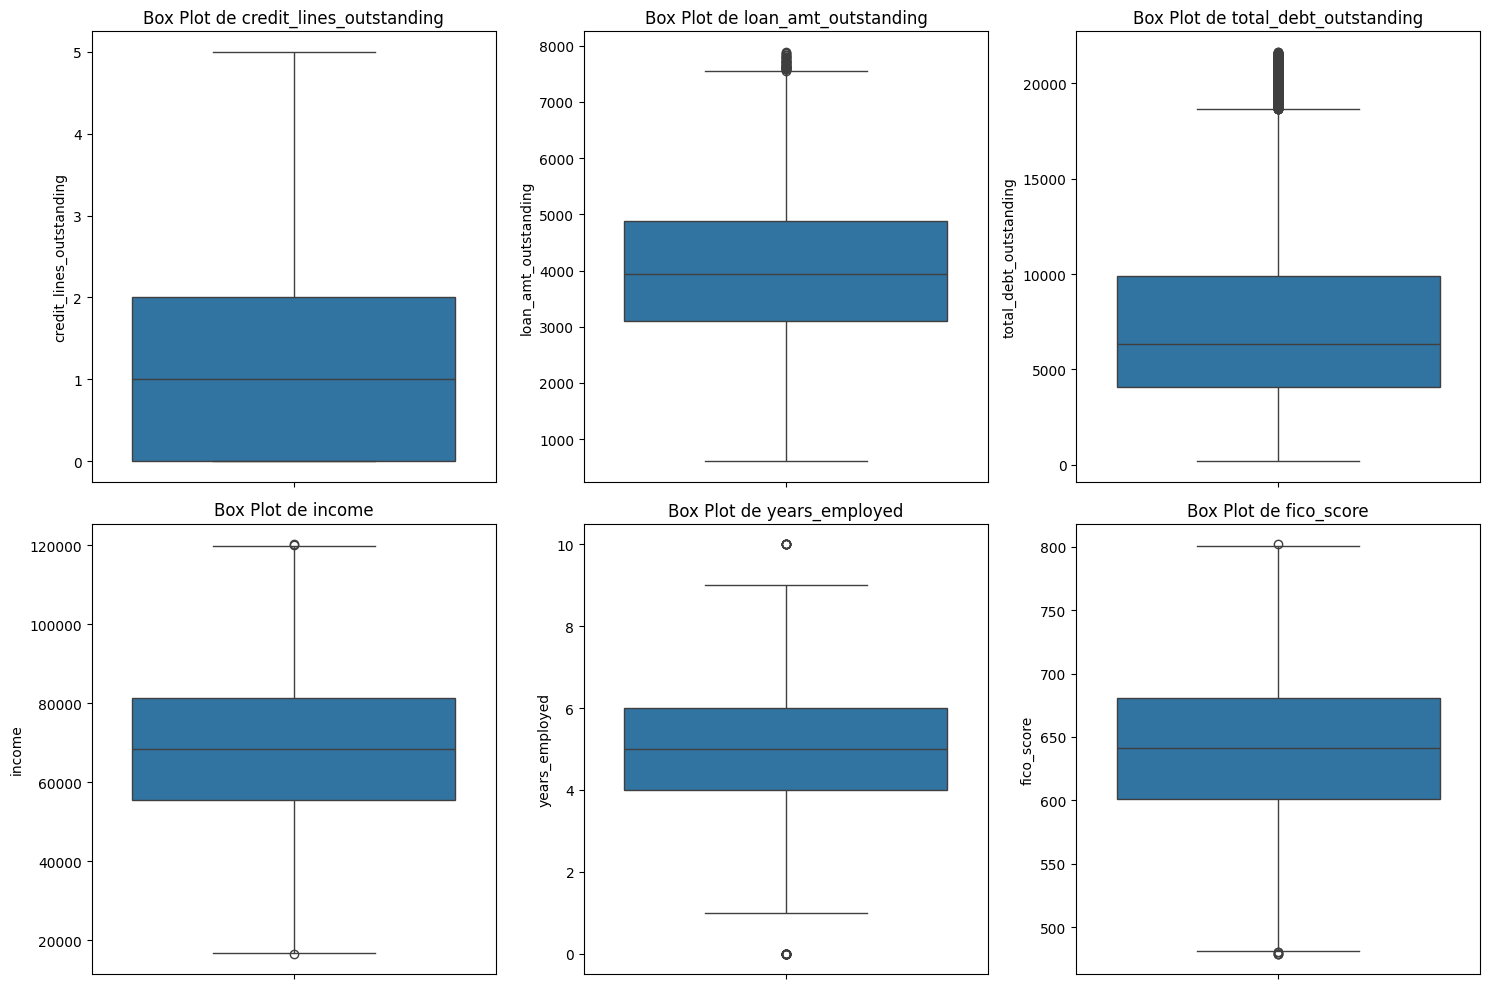

In [15]:
def detect_and_print_first_outlier(df, columns):
    for col in columns:
        # Calculer les quartiles
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Définir les bornes inférieure et supérieure
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identifier les outliers
        outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]
        
        # Afficher la première valeur des outliers si elle existe
        if not outliers.empty:
            print(f"Première valeur outlier pour '{col}': {outliers[col].iloc[0]}")
        else:
            print(f"Aucun outlier détecté pour '{col}'.")

# Liste des colonnes à analyser
cols = ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score']

# Appeler la fonction pour afficher les outliers
detect_and_print_first_outlier(df_cleaned, cols)

# Visualiser les box plots pour chaque colonne
plt.figure(figsize=(15, 10))
for i, col in enumerate(cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df_cleaned[col])
    plt.title(f'Box Plot de {col}')
plt.tight_layout()
plt.show()

Nous allons effacer les données des variables qui sont considérées comme des outliers et qui malgré la méthode es percentiles sont encore présents.

In [17]:
# Supprimer les données où 'loan_amt_outstanding' est supérieur à 7757
df_cleaned = df_cleaned[df_cleaned['loan_amt_outstanding'] <= 7757]# <?

# Supprimer les données où 'total_debt_outstanding' est supérieur à 18858
df_cleaned = df_cleaned[df_cleaned['total_debt_outstanding'] <= 18858] # <?

# Vérifier les résultats après nettoyage
print("Valeurs maximales et minimales après nettoyage:")
print(f"loan_amt_outstanding: Min = {df_cleaned['loan_amt_outstanding'].min()}, Max = {df_cleaned['loan_amt_outstanding'].max()}")
print(f"total_debt_outstanding: Min = {df_cleaned['total_debt_outstanding'].min()}, Max = {df_cleaned['total_debt_outstanding'].max()}")

# Afficher quelques lignes pour vérifier visuellement
print("\nQuelques exemples de données après nettoyage:")
print(df_cleaned.head())

Valeurs maximales et minimales après nettoyage:
loan_amt_outstanding: Min = 606, Max = 7757
total_debt_outstanding: Min = 195, Max = 18858

Quelques exemples de données après nettoyage:
   customer_id  credit_lines_outstanding  loan_amt_outstanding  \
0      8153374                         0                  5222   
1      7442532                         5                  1959   
2      2256073                         0                  3363   
3      4885975                         0                  4767   
4      4700614                         1                  1346   

   total_debt_outstanding  income  years_employed  fico_score  default  
0                    3915   78039               5         605        0  
1                    8229   26648               2         572        1  
2                    2028   65867               4         602        0  
3                    2502   74357               5         612        0  
4                    1769   23448               6   

In [18]:
df_cleaned.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,8.811000e+03,8811.000000,8811.000000,8811.000000,8811.000000,8811.000000,8811.000000,8811.000000
mean,4.991037e+06,1.103961,3999.834185,7034.655317,68066.786403,4.652366,641.852117,0.100670
std,2.298349e+06,1.428062,1289.418773,4257.986057,18805.754931,1.549567,57.742198,0.300908
min,1.000522e+06,0.000000,606.000000,195.000000,16667.000000,0.000000,479.000000,0.000000
25%,2.993442e+06,0.000000,3076.000000,3957.000000,54939.500000,4.000000,603.000000,0.000000
50%,4.998784e+06,1.000000,3899.000000,6163.000000,67821.000000,5.000000,642.000000,0.000000
75%,6.993414e+06,2.000000,4843.000000,9304.000000,81155.500000,6.000000,682.000000,0.000000
max,8.999789e+06,5.000000,7757.000000,18858.000000,120238.000000,10.000000,802.000000,1.000000


ça a fonctionné

Première valeur outlier pour 'loan_amt_outstanding': 7757
Première valeur outlier pour 'total_debt_outstanding': 18858


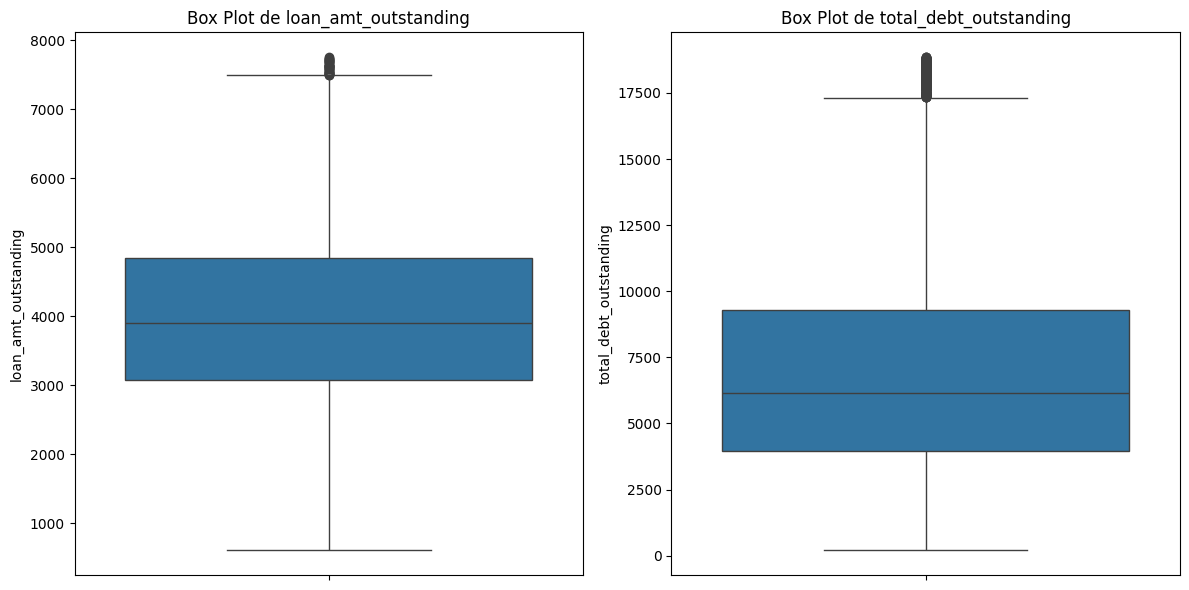

In [19]:
def print_first_outliers(df, columns):
    for col in columns:
        # Calculer les quartiles et l'IQR
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1

        # Définir les bornes inférieure et supérieure
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identifier les outliers
        outliers2 = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]

        # Afficher la première valeur des outliers si elle existe
        if not outliers2.empty:
            print(f"Première valeur outlier pour '{col}': {outliers2[col].iloc[0]}")
        else:
            print(f"Aucun outlier détecté pour '{col}'.")

# Colonnes à vérifier pour les outliers
columns_to_check = ['loan_amt_outstanding', 'total_debt_outstanding']

# Afficher les premières valeurs des outliers
print_first_outliers(df_cleaned, columns_to_check)

# Créer des box plots pour les colonnes 'loan_amt_outstanding' et 'total_debt_outstanding'
plt.figure(figsize=(12, 6))

# Box plot pour 'loan_amt_outstanding'
plt.subplot(1, 2, 1)
sns.boxplot(y=df_cleaned['loan_amt_outstanding'])
plt.title('Box Plot de loan_amt_outstanding')

# Box plot pour 'total_debt_outstanding'
plt.subplot(1, 2, 2)
sns.boxplot(y=df_cleaned['total_debt_outstanding'])
plt.title('Box Plot de total_debt_outstanding')

plt.tight_layout()
plt.show()

In [20]:
# Filtrer les lignes où 'loan_amt_outstanding' est supérieur à 7757
df_outliers = df_cleaned[df_cleaned['loan_amt_outstanding'] > 7757]

# Afficher les lignes où 'loan_amt_outstanding' est supérieur à 7757
print("Données où 'loan_amt_outstanding' > 7757:")

Données où 'loan_amt_outstanding' > 7757:


In [21]:
# Filtrer les lignes où 'total_debt_outstanding' est supérieur à 18858
df_outliers = df_cleaned[df_cleaned['total_debt_outstanding'] > 18858]

# Afficher les lignes où 'total_debt_outstanding' est supérieur à 18858
print("Données où 'total_debt_outstanding' > 18858:")

Données où 'total_debt_outstanding' > 18858:


Les données ont bien été supprimées

In [22]:
df_cleaned.shape

(8811, 8)

In [23]:
df = df_cleaned 

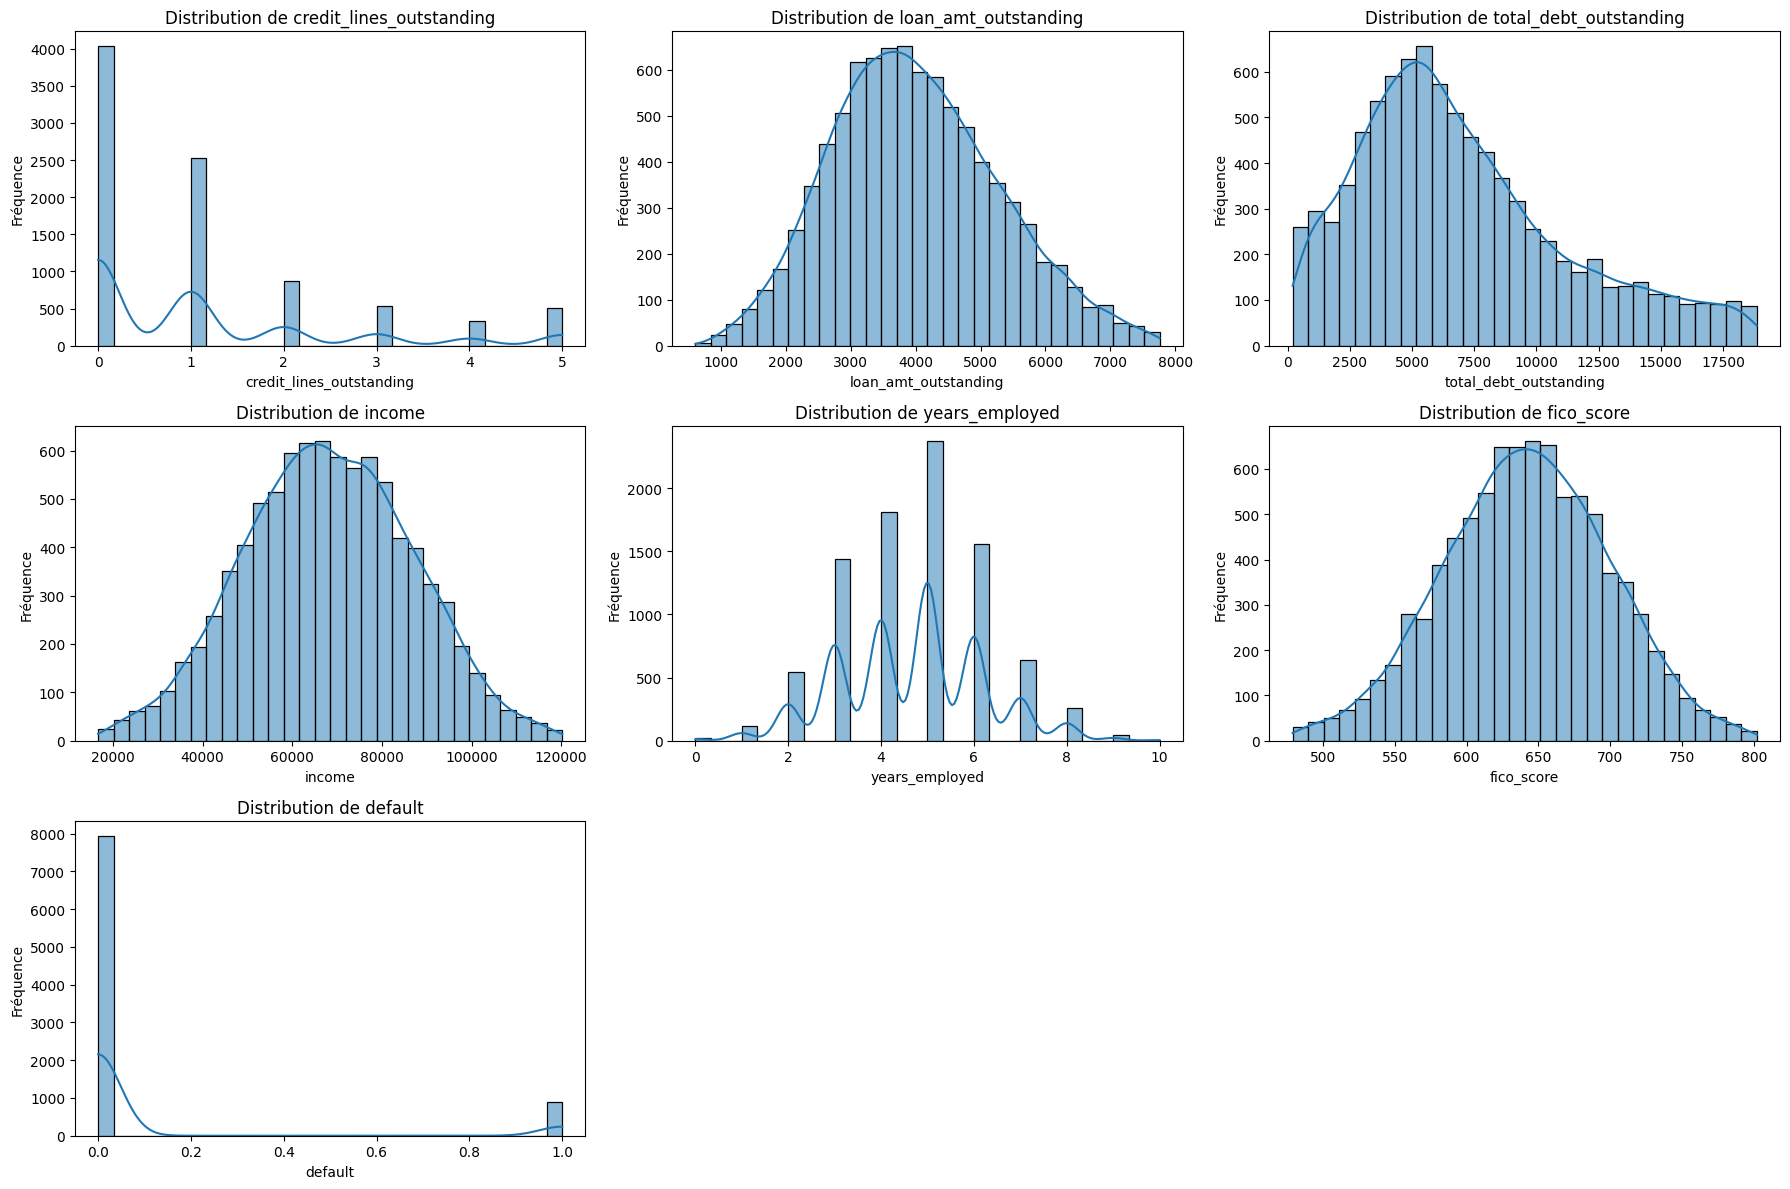

In [24]:
def analyze_data_distribution(df, columns):
    """
    Cette fonction analyse la distribution des données pour les colonnes spécifiées dans un DataFrame.
    
    Args:
    df (pd.DataFrame): Le DataFrame contenant les données.
    columns (list): La liste des colonnes à analyser.
    """
    # Définir la taille de la figure
    plt.figure(figsize=(18, 12))
    
    for i, col in enumerate(columns, 1):
        plt.subplot(3, 3, i)
        
        if df[col].dtype == 'object' or df[col].dtype.name == 'category':
            # Pour les variables catégorielles ou de type object, afficher un diagramme en barres
            sns.countplot(data=df, x=col)
            plt.title(f'Distribution de {col}')
            plt.xticks(rotation=45)  # Rotation des labels de l'axe des x si nécessaire
        else:
            # Pour les variables numériques, afficher un histogramme
            sns.histplot(df[col], bins=30, kde=True)
            plt.title(f'Distribution de {col}')
        
        plt.xlabel(col)
        plt.ylabel('Fréquence')
    
    plt.tight_layout()
    plt.show()

# Liste des colonnes à analyser
columns_to_analyze = ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score', 'default']

# Analyser la distribution des données
analyze_data_distribution(df, columns_to_analyze)

Les données suivent une loi normale sauf pour la colonne 'years_employed'

Valeurs uniques pour 'years_employed':
[ 5  2  4  6  3  7  8  1  9 10  0]

Statistiques descriptives pour 'years_employed':
count    8811.000000
mean        4.652366
std         1.549567
min         0.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        10.000000
Name: years_employed, dtype: float64


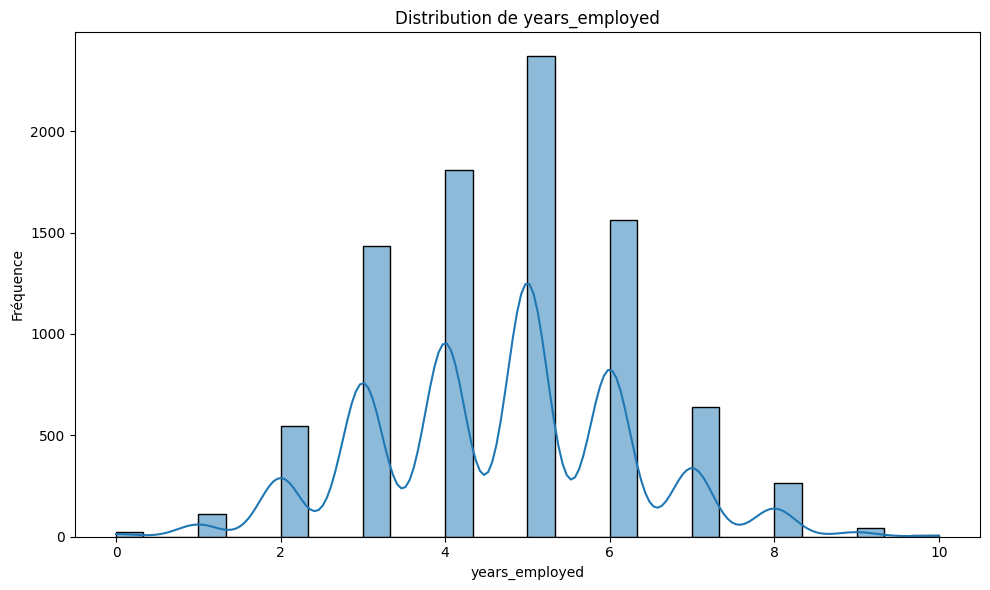

In [25]:
def analyze_column_distribution(df, column):
    """
    Analyse la distribution d'une colonne spécifique dans un DataFrame.
    
    Args:
    df (pd.DataFrame): Le DataFrame contenant les données.
    column (str): Le nom de la colonne à analyser.
    """
    plt.figure(figsize=(10, 6))
    
    if df[column].dtype == 'object' or df[column].dtype.name == 'category':
        # Pour les variables catégorielles ou de type object, afficher un diagramme en barres
        sns.countplot(data=df, x=column)
        plt.title(f'Distribution de {column}')
        plt.xticks(rotation=45)  # Rotation des labels de l'axe des x si nécessaire
    else:
        # Pour les variables numériques, afficher un histogramme avec une courbe de densité
        sns.histplot(df[column], bins=30, kde=True)
        plt.title(f'Distribution de {column}')
        plt.xlabel(column)
        plt.ylabel('Fréquence')
        
    plt.tight_layout()
    plt.show()
    
# Analyser les valeurs uniques et les statistiques descriptives
print("Valeurs uniques pour 'years_employed':")
print(df['years_employed'].unique())
print("\nStatistiques descriptives pour 'years_employed':")
print(df['years_employed'].describe())

# Analyser la distribution de 'years_employed'
analyze_column_distribution(df, 'years_employed')

In [26]:
# Afficher les valeurs manquantes pour chaque colonne
missing_values = df.isnull().sum()
print("Valeurs manquantes par colonne:")
print(missing_values)

Valeurs manquantes par colonne:
customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64


In [28]:
# Définir les intervalles pour chaque colonne
def categorize_column(df, column, bins, labels):
    """
    Convertit une colonne numérique en colonne catégorielle en fonction des intervalles spécifiés.
    
    Args:
    df (pd.DataFrame): Le DataFrame contenant les données.
    column (str): Le nom de la colonne à transformer.
    bins (list): Les bornes des intervalles.
    labels (list): Les labels pour les catégories.
    
    Returns:
    pd.DataFrame: Le DataFrame avec la colonne catégorielle ajoutée.
    """
    df[column + '_category'] = pd.cut(df[column], bins=bins, labels=labels, include_lowest=True)
    return df

# Définir les intervalles et labels pour chaque colonne
bins_dict = {
    'credit_lines_outstanding': [0, 2, 4, 5],
    'loan_amt_outstanding': [0, 1000, 3000, 5000, 7000, 8000],
    'total_debt_outstanding': [0, 2000, 4000, 6000, 8000, 10000, 12000, 15000, 20000],
    'income': [0, 20000, 40000, 60000, 80000, 100000, 120000],
    'years_employed': [0, 1, 3, 5, 10]
}

labels_dict = {
    'credit_lines_outstanding': ['0-2', '2-4', '4+'],
    'loan_amt_outstanding': ['0-1K', '1K-3K', '3K-5K', '5K-7K', '7K-8K'],
    'total_debt_outstanding': ['0-2K', '2K-4K', '4K-6K', '6K-8K', '8K-10K', '10K-12K', '12K-15K', '15K-20K'],
    'income': ['0-20K', '20K-40K', '40K-60K', '60K-80K', '80K-100K', '100K-120K'],
    'years_employed': ['0-1Y', '1Y-3Y', '3Y-5Y', '5Y-10Y']
}

# Appliquer la transformation à chaque colonne
for column in bins_dict.keys():
    df = categorize_column(df, column, bins_dict[column], labels_dict[column])

# Afficher les premières lignes pour vérifier les résultats
print(df.head())

# Afficher la distribution des nouvelles colonnes catégorielles
for column in bins_dict.keys():
    print(f'\nDistribution de {column}_category:')
    print(df[column + '_category'].value_counts())

   customer_id  credit_lines_outstanding  loan_amt_outstanding  \
0      8153374                         0                  5222   
1      7442532                         5                  1959   
2      2256073                         0                  3363   
3      4885975                         0                  4767   
4      4700614                         1                  1346   

   total_debt_outstanding  income  years_employed  fico_score  default  \
0                    3915   78039               5         605        0   
1                    8229   26648               2         572        1   
2                    2028   65867               4         602        0   
3                    2502   74357               5         612        0   
4                    1769   23448               6         631        0   

  credit_lines_outstanding_category loan_amt_outstanding_category  \
0                               0-2                         5K-7K   
1                   

In [29]:
df.columns

Index(['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding',
       'total_debt_outstanding', 'income', 'years_employed', 'fico_score',
       'default', 'credit_lines_outstanding_category',
       'loan_amt_outstanding_category', 'total_debt_outstanding_category',
       'income_category', 'years_employed_category'],
      dtype='object')

In [30]:
# Fonction pour créer un graphique en camembert avec Plotly
def plot_pie_chart(df, column):
    """
    Crée un graphique en camembert pour une colonne catégorielle en affichant les pourcentages.
    
    Args:
    df (pd.DataFrame): Le DataFrame contenant les données.
    column (str): Le nom de la colonne catégorielle à visualiser.
    """
    # Calculer les fréquences et pourcentages
    counts = df[column].value_counts()
    percentages = (counts / counts.sum() * 100).reset_index()
    percentages.columns = [column, 'Percentage']
    
    # Créer le graphique en camembert
    fig = px.pie(percentages, names=column, values='Percentage', title=f'Distribution de {column}', 
                 labels={column: column, 'Percentage': 'Pourcentage'})
    
    # Mettre à jour le layout pour une meilleure visualisation
    fig.update_layout(
        margin=dict(t=50, b=50, l=50, r=50)
    )
    
    # Afficher le graphique
    fig.show()

# Liste des colonnes catégorielles à analyser
categorical_columns = [
    'credit_lines_outstanding_category',
    'loan_amt_outstanding_category',
    'total_debt_outstanding_category',
    'income_category',
    'years_employed_category'
]

# Créer des graphiques en camembert pour chaque colonne catégorielle
for column in categorical_columns:
    plot_pie_chart(df, column)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2368
           1       1.00      0.96      0.98       276

    accuracy                           1.00      2644
   macro avg       1.00      0.98      0.99      2644
weighted avg       1.00      1.00      1.00      2644

ROC AUC Score: 0.9999984699373287


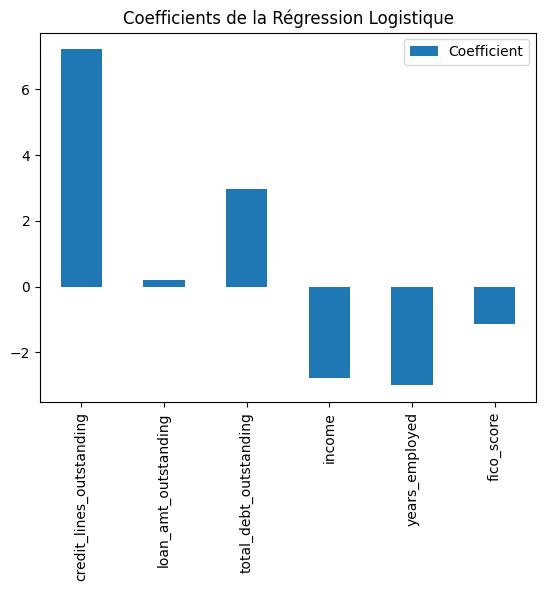

In [31]:

# Sélectionner les variables explicatives (features) et la variable cible (target)
X = df[['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score']]
y = df['default']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normaliser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Construire et entraîner le modèle
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Faire des prédictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Évaluer le modèle
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba)}")

# Visualiser les coefficients du modèle
coefficients = pd.DataFrame(model.coef_.flatten(), X.columns, columns=['Coefficient'])
coefficients.plot(kind='bar')
plt.title('Coefficients de la Régression Logistique')
plt.show()

Modèle Performant : Le modèle a une très bonne performance pour les deux classes avec des précisions, rappels, et F1-scores proches de 1.00.
MAIS > Problème Potentiel : Le rappel de 0.96 pour la classe 1 suggère qu'il y a quelques faux négatifs (prédictions incorrectes pour les défauts). Cela peut être critique si l'identification des défauts est cruciale.
Ce rapport indique que le modèle est très performant, mais il est important d'examiner si les faux négatifs pour les défauts ont des implications importantes pour les décisions prises en fonction des prédictions du modèle.

In [32]:
# Convertir explicitement toutes les données en float, après encodage
X = pd.DataFrame(X).apply(pd.to_numeric, errors='coerce')

In [33]:
client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

In [34]:
all_experiments=client.search_experiments()
all_experiments

MlflowException: API request to http://127.0.0.1:8080/api/2.0/mlflow/experiments/search failed with exception HTTPConnectionPool(host='127.0.0.1', port=8080): Max retries exceeded with url: /api/2.0/mlflow/experiments/search (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000280CF4145C0>: Failed to establish a new connection: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée'))

In [35]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")

In [ ]:
from mlflow.tracking import MlflowClient
import mlflow

# Initialisation de la connexion MLflow
mlflow.set_tracking_uri("http://127.0.0.1:8080")
client = MlflowClient()

# Description de l'expérience
experiment_description = (
    """
    Voici pourquoi ces modèles sont utilisés pour ce projet :

    K-Nearest Neighbors (KNN) : Utilisé pour sa simplicité et son efficacité dans les petits ensembles de données. 
    Il permet de comprendre les tendances de base et de comparer la performance de modèles plus complexes.
    Random Forest : Choisi pour sa robustesse et sa capacité à gérer les données déséquilibrées et à éviter le surapprentissage.
    Les différentes configurations d'hyperparamètres permettent d'optimiser le modèle.
    Régression Logistique : Utilisée comme modèle de référence en raison de sa simplicité et de son interprétabilité. 
    C'est un excellent point de départ pour comprendre la relation entre les variables.
    Réseaux de Neurones : Mis en œuvre pour exploiter les capacités de capture des relations non linéaires complexes,
    idéal pour les données où les modèles linéaires sont insuffisants.
    Gradient Boosting Classifier (GBC) : En cours de test pour son efficacité à améliorer la précision par le biais de 
    l'augmentation des performances des arbres de décision faibles.
    Ces modèles sont choisis pour diversifier les approches et s'assurer que le meilleur modèle possible est sélectionné pour 
    l'application Streamlit, garantissant une précision optimale et une fiabilité pour les prédictions.
    """
)

# Tags de l'expérience
experiment_tag = {
    "project_name": "Projet Mlops2",
    "Team": "Maud Mayousse-Aumiphin Couant Mariam"
}

# Création de l'expérience
experiment_id = client.create_experiment(
    name="Projet_Models2",
    tags=experiment_tag
)

# Affichage de l'ID de l'expérience créée
print(f"Experiment created with ID: {experiment_id}")

# Recherche de toutes les expériences
all_experiments = client.search_experiments()
for exp in all_experiments:
    print(f"Experiment {exp.name} with ID {exp.experiment_id}")

# Afficher les expériences créées
print("All experiments:", all_experiments)


RestException: RESOURCE_ALREADY_EXISTS: Experiment 'Projet_Models2' already exists.

In [ ]:

# Retourne les métadonnées de l'expérience
defaut_experiment = mlflow.set_experiment("Projet_Models2")

# Définir un nom pour cette itération de l'entraînement.
# Si ce nom n'est pas défini, un nom unique sera automatiquement généré pour votre exécution.
run_name = "Projet_Models_rf_test"

# Définir un chemin pour les artefacts où le modèle sera sauvegardé.
artifact_path = "rf_Projet_Models2"


Experience 1 Random Forest

In [ ]:
X.dtypes

customer_id                             int64
credit_lines_outstanding                int64
loan_amt_outstanding                    int32
total_debt_outstanding                  int32
income                                  int32
years_employed                          int64
fico_score                              int64
credit_lines_outstanding_category    category
loan_amt_outstanding_category        category
total_debt_outstanding_category      category
income_category                      category
years_employed_category              category
dtype: object

In [ ]:
# Identifier les colonnes catégorielles
categorical_columns = X.select_dtypes(include=['category']).column

AttributeError: 'DataFrame' object has no attribute 'column'

1. Test Random Classification_1

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import mlflow
import mlflow.sklearn
import pandas as pd

# Diviser les données en caractéristiques (features) et cible (target)
X = df.drop(columns=["default"])  # Supprimer la colonne cible 'default'
y = df["default"]  # La colonne cible 'default'

# Identifier les colonnes catégorielles
categorical_columns = X.select_dtypes(include=['category']).columns

# Encoder les colonnes catégorielles
if len(categorical_columns) > 0:
    one_hot_encoder = ColumnTransformer(
        transformers=[('cat', OneHotEncoder(drop='first'), categorical_columns)],
        remainder='passthrough'
    )
    X = one_hot_encoder.fit_transform(X)

# Convertir les données encodées en DataFrame
X = pd.DataFrame(X.toarray() if hasattr(X, "toarray") else X)

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Paramètres du modèle
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy"],
    "bootstrap": [True],
    "random_state": [42]
}

# Instancier le RandomForestClassifier
rf = RandomForestClassifier()

# Effectuer une recherche par grille pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Meilleurs paramètres trouvés par la recherche par grille
best_params = grid_search.best_params_

# Entraîner le RandomForestClassifier avec les meilleurs paramètres
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(X_train, y_train)

# Prédire sur l'ensemble de validation
y_pred = rf_best.predict(X_val)

# Calculer les métriques d'évaluation
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='binary')
recall = recall_score(y_val, y_pred, average='binary')
f1 = f1_score(y_val, y_pred, average='binary')

# Rassembler les métriques à enregistrer
metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1
}

# Démarrer le contexte d'exécution MLflow
mlflow.set_experiment("Projet_Models2")
run_name = "Projet_Models_random_forest_1"  
artifact_path = "rf_Projet_Models2"  

with mlflow.start_run(run_name=run_name) as run:
    # Enregistrer les paramètres utilisés pour l'ajustement du modèle
    mlflow.log_params(best_params)

    # Enregistrer les métriques d'évaluation calculées lors de la validation
    mlflow.log_metrics(metrics)

    # Enregistrer une instance du modèle entraîné pour une utilisation ultérieure
    mlflow.sklearn.log_model(
        sk_model=rf_best, 
        input_example=X_val[:5],  # Exemple d'entrée limité à quelques lignes
        artifact_path=artifact_path
    )


c:\Users\aumiphin\Downloads\Projet_Mlops\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

2024/09/04 22:52:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run Projet_Models_random_forest_1 at: http://127.0.0.1:8080/#/experiments/583114210000402989/runs/d0de44cfa1574970ad0d5bf011cbfbc2.
2024/09/04 22:52:28 INFO mlflow.t

2. Test Random Classification_2

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn
import pandas as pd

# Diviser les données en caractéristiques (features) et cible (target)
X = df.drop(columns=["default"])  # Supprimer la colonne cible 'default'
y = df["default"]  # La colonne cible 'default'

# Identifier les colonnes catégorielles
categorical_columns = X.select_dtypes(include=['category']).columns
# Identifier les colonnes numériques
numeric_columns = X.select_dtypes(include=['int64', 'int32']).columns

# Définir le préprocesseur avec OneHotEncoder pour les colonnes catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_columns),  # Garder les colonnes numériques telles quelles
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)  # Encoder les colonnes catégorielles
    ]
)

# Créer un pipeline avec préprocessing et modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))  # Instancier RandomForestClassifier avec random_state
])

# Définir les paramètres pour GridSearch
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__bootstrap': [True]
}

# Effectuer une recherche par grille pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X, y)

# Meilleurs paramètres trouvés par la recherche par grille
best_params = grid_search.best_params_

# Entraîner le modèle avec les meilleurs paramètres
best_model = grid_search.best_estimator_

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle
best_model.fit(X_train, y_train)

# Prédire sur l'ensemble de validation
y_pred = best_model.predict(X_val)

# Calculer les métriques d'évaluation
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='binary')
recall = recall_score(y_val, y_pred, average='binary')
f1 = f1_score(y_val, y_pred, average='binary')

# Rassembler les métriques à enregistrer
metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1
}

# Démarrer le contexte d'exécution MLflow
mlflow.set_experiment("Projet_Models2")
run_name = "Projet_Models_random_forest_2"  
artifact_path = "rf_Projet_Models2"  

with mlflow.start_run(run_name=run_name) as run:
    # Enregistrer les paramètres utilisés pour l'ajustement du modèle
    mlflow.log_params(best_params)

    # Enregistrer les métriques d'évaluation calculées lors de la validation
    mlflow.log_metrics(metrics)

    # Enregistrer une instance du modèle entraîné pour une utilisation ultérieure
    mlflow.sklearn.log_model(
        sk_model=best_model, 
        input_example=X_val[:5],  # Exemple d'entrée limité à quelques lignes
        artifact_path=artifact_path
    )


c:\Users\aumiphin\Downloads\Projet_Mlops\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

2024/09/04 23:09:26 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: MlflowException("Failed to enforce schema of data '      customer_id  credit_lines_outstanding  loan_amt_outstanding  

3. Test Random Classification 3

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn

# Diviser les données en caractéristiques (features) et cible (target)
X = df.drop(columns=["default"])  # Supprimer la colonne cible 'default'
y = df["default"]  # La colonne cible 'default'

# Identifier les colonnes catégorielles
categorical_columns = X.select_dtypes(include=['category']).columns
# Identifier les colonnes numériques
numeric_columns = X.select_dtypes(include=['int64', 'int32']).columns

# Définir le préprocesseur avec OneHotEncoder pour les colonnes catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_columns),  # Garder les colonnes numériques telles quelles
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)  # Encoder les colonnes catégorielles
    ]
)

# Créer un pipeline avec préprocessing et modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))  # Instancier RandomForestClassifier avec random_state
])

# Définir les paramètres pour GridSearch
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 15, 20],
    'classifier__min_samples_split': [5, 10],
    'classifier__min_samples_leaf': [2, 4],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__criterion': ['gini'],
    'classifier__bootstrap': [True]
}

# Effectuer une recherche par grille pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X, y)

# Meilleurs paramètres trouvés par la recherche par grille
best_params = grid_search.best_params_

# Entraîner le modèle avec les meilleurs paramètres
best_model = grid_search.best_estimator_

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle
best_model.fit(X_train, y_train)

# Prédire sur l'ensemble de validation
y_pred = best_model.predict(X_val)

# Calculer les métriques d'évaluation
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='binary')
recall = recall_score(y_val, y_pred, average='binary')
f1 = f1_score(y_val, y_pred, average='binary')

# Rassembler les métriques à enregistrer
metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1
}

# Démarrer le contexte d'exécution MLflow
mlflow.set_experiment("Projet_Models2")
run_name = "Projet_Models_random_forest_3"  
artifact_path = "rf_Projet_Models3"  

with mlflow.start_run(run_name=run_name) as run:
    # Enregistrer les paramètres utilisés pour l'ajustement du modèle
    mlflow.log_params(best_params)

    # Enregistrer les métriques d'évaluation calculées lors de la validation
    mlflow.log_metrics(metrics)

    # Enregistrer une instance du modèle entraîné pour une utilisation ultérieure
    mlflow.sklearn.log_model(
        sk_model=best_model, 
        input_example=X_val[:5],  # Exemple d'entrée limité à quelques lignes
        artifact_path=artifact_path
    )


c:\Users\aumiphin\Downloads\Projet_Mlops\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

2024/09/04 23:14:51 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: MlflowException("Failed to enforce schema of data '      customer_id  credit_lines_outstanding  loan_amt_outstanding  

Test 4 - LogisticRegression 1

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn

# Définir l'expérience dans MLflow
mlflow.set_experiment("Projet_Models2")
run_name = "Projet_Models_Logistic_regression_1"
artifact_path = "rl_Projet_Models2"

# Diviser les données en caractéristiques (features) et cible (target)
X = df.drop(columns=["default"])  # Supprimer la colonne cible 'default'
y = df["default"]  # La colonne cible 'default'

# Identifier les colonnes catégorielles et numériques
categorical_columns = X.select_dtypes(include=['category']).columns
numeric_columns = X.select_dtypes(include=['int64', 'int32']).columns

# Définir le préprocesseur avec OneHotEncoder pour les colonnes catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_columns),  # Garder les colonnes numériques telles quelles
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)  # Encoder les colonnes catégorielles
    ]
)

# Créer un pipeline avec préprocessing et modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))  # Initialiser la régression logistique
])

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle avec le pipeline
pipeline.fit(X_train, y_train)

# Prédire sur l'ensemble de validation
y_pred = pipeline.predict(X_val)

# Calculer les métriques d'évaluation
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Regrouper les métriques pour l'enregistrement
metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1
}

# Démarrer le contexte d'exécution MLflow
with mlflow.start_run(run_name=run_name) as run:
    # Enregistrer les paramètres utilisés pour l'ajustement du modèle
    mlflow.log_param("solver", "liblinear")
    mlflow.log_param("random_state", 42)

    # Enregistrer les métriques d'évaluation calculées lors de la validation
    mlflow.log_metrics(metrics)

    # Enregistrer une instance du modèle entraîné pour une utilisation ultérieure
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        input_example=X_val.head(),  # Exemple d'entrée limité à quelques lignes
        artifact_path=artifact_path
    )

print("Performance du modèle :", metrics)


c:\Users\aumiphin\Downloads\Projet_Mlops\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

2024/09/04 23:17:34 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: MlflowException("Failed to enforce schema of data '      customer_id  credit_lines_outstanding  loan_amt_outstanding  

Performance du modèle : {'accuracy': 0.9812819058423142, 'precision': 0.9204545454545454, 'recall': 0.8950276243093923, 'f1_score': 0.907563025210084}


Test 5 - Neural Network

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn

# Définir l'expérience dans MLflow
mlflow.set_experiment("Projet_Models2")
run_name = "Projet_Models_neural_network_test_1"
artifact_path = "knn_Projet_Models2"

# Diviser les données en caractéristiques (features) et cible (target)
X = df.drop(columns=["default"])  # Supprimer la colonne cible 'default'
y = df["default"]  # La colonne cible 'default'

# Identifier les colonnes catégorielles et numériques
categorical_columns = X.select_dtypes(include=['category']).columns
numeric_columns = X.select_dtypes(include=['int64', 'int32']).columns

# Définir le préprocesseur avec OneHotEncoder pour les colonnes catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_columns),  # Garder les colonnes numériques telles quelles
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)  # Encoder les colonnes catégorielles
    ]
)

# Créer un pipeline avec préprocessing et modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))  # Initialiser K-Nearest Neighbors
])

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle avec le pipeline
pipeline.fit(X_train, y_train)

# Prédire sur l'ensemble de validation
y_pred = pipeline.predict(X_val)

# Calculer les métriques d'évaluation
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Rassembler les métriques à enregistrer
metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1
}

# Démarrer le contexte d'exécution MLflow
with mlflow.start_run(run_name=run_name) as run:
    # Enregistrer les paramètres utilisés pour l'ajustement du modèle
    mlflow.log_param("n_neighbors", 5)  # Ici, vous pouvez enregistrer la valeur du paramètre n_neighbors

    # Enregistrer les métriques d'évaluation calculées lors de la validation
    mlflow.log_metrics(metrics)

    # Enregistrer une instance du modèle entraîné pour une utilisation ultérieure
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        input_example=X_val.head(),  # Exemple d'entrée limité à quelques lignes
        artifact_path=artifact_path
    )

print("Performance du modèle :", metrics)


c:\Users\aumiphin\Downloads\Projet_Mlops\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

2024/09/04 23:24:09 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: MlflowException("Failed to enforce schema of data '      customer_id  credit_lines_outstanding  loan_amt_outstanding  

Performance du modèle : {'accuracy': 0.9018718094157686, 'precision': 0.7857142857142857, 'recall': 0.06077348066298342, 'f1_score': 0.11282051282051282}


Test 6 - Neural Networks 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn

# Définir l'expérience dans MLflow
mlflow.set_experiment("Projet_Models2")
run_name = "Projet_Models_neural_network_test_2"
artifact_path = "knn_Projet_Models2"

# Diviser les données en caractéristiques (features) et cible (target)
X = df.drop(columns=["default"])  # Supprimer la colonne cible 'default'
y = df["default"]  # La colonne cible 'default'

# Identifier les colonnes catégorielles et numériques
categorical_columns = X.select_dtypes(include=['category']).columns
numeric_columns = X.select_dtypes(include=['int64', 'int32']).columns

# Vérifier les colonnes identifiées
print("Colonnes catégorielles identifiées : ", categorical_columns)
print("Colonnes numériques identifiées : ", numeric_columns)

# Définir le préprocesseur avec OneHotEncoder pour les colonnes catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_columns),  # Garder les colonnes numériques telles quelles
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)  # Encoder les colonnes catégorielles
    ]
)

# Créer un pipeline avec préprocessing et modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))  # Initialiser K-Nearest Neighbors
])

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle avec le pipeline
pipeline.fit(X_train, y_train)

# Prédire sur l'ensemble de validation
y_pred = pipeline.predict(X_val)

# Calculer les métriques d'évaluation
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Rassembler les métriques à enregistrer
metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1
}

# Afficher un échantillon des données transformées pour vérification
X_val_transformed = preprocessor.transform(X_val)
print("Échantillon des données transformées : \n", X_val_transformed[:5])

# Démarrer le contexte d'exécution MLflow
with mlflow.start_run(run_name=run_name) as run:
    # Enregistrer les paramètres utilisés pour l'ajustement du modèle
    mlflow.log_param("n_neighbors", 5)  # Ici, vous pouvez enregistrer la valeur du paramètre n_neighbors

    # Enregistrer les métriques d'évaluation calculées lors de la validation
    mlflow.log_metrics(metrics)

    # Enregistrer une instance du modèle entraîné pour une utilisation ultérieure
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        input_example=X_val.head(),  # Exemple d'entrée limité à quelques lignes
        artifact_path=artifact_path
    )

print("Performance du modèle :", metrics)


Colonnes catégorielles identifiées :  Index(['credit_lines_outstanding_category', 'loan_amt_outstanding_category',
       'total_debt_outstanding_category', 'income_category',
       'years_employed_category'],
      dtype='object')
Colonnes numériques identifiées :  Index(['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding',
       'total_debt_outstanding', 'income', 'years_employed', 'fico_score'],
      dtype='object')
Échantillon des données transformées : 
 [[1.682683e+06 0.000000e+00 3.683000e+03 7.652000e+03 7.486800e+04
  4.000000e+00 6.490000e+02 1.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00]
 [1.193424e+06 0.000000e+00 1.853000e+03 2.393000e+03 3.223100

c:\Users\aumiphin\Downloads\Projet_Mlops\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

2024/09/04 23:24:18 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: MlflowException("Failed to enforce schema of data '      customer_id  credit_lines_outstanding  loan_amt_outstanding  

Performance du modèle : {'accuracy': 0.9018718094157686, 'precision': 0.7857142857142857, 'recall': 0.06077348066298342, 'f1_score': 0.11282051282051282}


7 Test Gradient Boosting Classifie_test 1

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import mlflow
import mlflow.sklearn

# Définir l'expérience dans MLflow
mlflow.set_experiment("Projet_Models2")
run_name = "Projet_Models_gbc_test_1"
artifact_path = "gbc_Projet_Models2"

# Diviser les données en caractéristiques (features) et cible (target)
X = df.drop(columns=["default"])  # Supprimer la colonne cible 'default'
y = df["default"]  # La colonne cible 'default'

# Identifier les colonnes catégorielles et numériques
categorical_columns = X.select_dtypes(include=['category']).columns
numeric_columns = X.select_dtypes(include=['int64', 'int32']).columns

# Définir le préprocesseur avec OneHotEncoder pour les colonnes catégorielles et StandardScaler pour les colonnes numériques
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),  # Normaliser les colonnes numériques
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)  # Encoder les colonnes catégorielles
    ]
)

# Créer un pipeline avec préprocessing et modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))  # Initialiser Gradient Boosting Classifier
])

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir une grille d'hyperparamètres pour GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}

# Rechercher les meilleurs hyperparamètres avec GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Meilleurs paramètres trouvés par la recherche par grille
best_params = grid_search.best_params_

# Entraîner le modèle avec les meilleurs paramètres
best_pipeline = grid_search.best_estimator_

# Prédire sur l'ensemble de validation
y_pred = best_pipeline.predict(X_val)
y_prob = best_pipeline.predict_proba(X_val)[:, 1]

# Calculer les métriques d'évaluation
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_prob)

# Rassembler les métriques à enregistrer
metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "roc_auc": roc_auc
}

# Afficher un échantillon des données transformées pour vérification
X_val_transformed = best_pipeline.named_steps['preprocessor'].transform(X_val)
print("Échantillon des données transformées : \n", X_val_transformed[:5])

# Démarrer le contexte d'exécution MLflow
with mlflow.start_run(run_name=run_name) as run:
    # Enregistrer les meilleurs paramètres utilisés pour l'ajustement du modèle
    mlflow.log_params(best_params)

    # Enregistrer les métriques d'évaluation calculées lors de la validation
    mlflow.log_metrics(metrics)

    # Enregistrer une instance du modèle entraîné pour une utilisation ultérieure
    mlflow.sklearn.log_model(
        sk_model=best_pipeline,
        artifact_path=artifact_path
    )

print("Performance du modèle :", metrics)


Échantillon des données transformées : 
 [[-1.43991008 -0.7711471  -0.24440883  0.14789775  0.36557384 -0.41916436
   0.12457935  1.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          1.          0.          0.
   0.          0.          0.          1.          0.          0.
   0.          0.          1.          0.        ]
 [-1.65324248 -0.7711471  -1.66974043 -1.09019628 -1.9130921   0.22870196
  -1.41677523  1.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.
   0.          1.          0.          0.          0.          0.
   0.          1.          0.          0.          0.          0.
   0.          0.          1.          0.        ]
 [-0.88142244 -0.7711471  -0.88308201 -0.61652349 -0.5751902  -1.06703068
  -2.09220027  1.          0.          0.          0.          1.
   0.          0.          0.          0.

2024/09/05 18:38:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/05 18:38:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run Projet_Models_gbc_test_1 at: http://127.0.0.1:8080/#/experiments/583114210000402989/runs/b9a0f3cc9b0f467ea74a52b1c894bb19.
2024/09/05 18:38:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/583114210000402989.


Performance du modèle : {'accuracy': 0.994895065229722, 'precision': 0.9725274725274725, 'recall': 0.9779005524861878, 'f1_score': 0.9752066115702479, 'roc_auc': 0.9998463375963009}


In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import mlflow.sklearn

# Définir l'expérience dans MLflow
mlflow.set_experiment("Projet_Models2")
run_name = "Projet_Models_gbc_test_2"
artifact_path = "gbc_Projet_Models2"

# Diviser les données en caractéristiques (features) et cible (target)
X = df.drop(columns=["default"])  # Supprimer la colonne cible 'default'
y = df["default"]  # La colonne cible 'default'

# Identifier les colonnes catégorielles et numériques
categorical_columns = X.select_dtypes(include=['category']).columns
numeric_columns = X.select_dtypes(include=['int64', 'int32']).columns

# Vérifier les colonnes identifiées
print("Colonnes catégorielles identifiées : ", categorical_columns)
print("Colonnes numériques identifiées : ", numeric_columns)

# Définir le préprocesseur avec OneHotEncoder pour les colonnes catégorielles et StandardScaler pour les colonnes numériques
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),  # Normaliser les colonnes numériques
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)  # Encoder les colonnes catégorielles
    ]
)

# Créer un pipeline avec préprocessing et modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))  # Initialiser Gradient Boosting Classifier
])

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle avec le pipeline
pipeline.fit(X_train, y_train)

# Prédire sur l'ensemble de validation
y_pred = pipeline.predict(X_val)

# Calculer les métriques d'évaluation
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Rassembler les métriques à enregistrer
metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1
}

# Afficher un échantillon des données transformées pour vérification
X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)
print("Échantillon des données transformées : \n", X_val_transformed[:5])

# Démarrer le contexte d'exécution MLflow
with mlflow.start_run(run_name=run_name) as run:
    # Enregistrer les paramètres utilisés pour l'ajustement du modèle
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("max_depth", 3)
    mlflow.log_param("random_state", 42)

    # Enregistrer les métriques d'évaluation calculées lors de la validation
    mlflow.log_metrics(metrics)

    # Enregistrer une instance du modèle entraîné pour une utilisation ultérieure
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path=artifact_path
    )

print("Performance du modèle :", metrics)


Colonnes catégorielles identifiées :  Index(['credit_lines_outstanding_category', 'loan_amt_outstanding_category',
       'total_debt_outstanding_category', 'income_category',
       'years_employed_category'],
      dtype='object')
Colonnes numériques identifiées :  Index(['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding',
       'total_debt_outstanding', 'income', 'years_employed', 'fico_score'],
      dtype='object')
Échantillon des données transformées : 
 [[-1.43991008 -0.7711471  -0.24440883  0.14789775  0.36557384 -0.41916436
   0.12457935  1.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          1.          0.          0.
   0.          0.          0.          1.          0.          0.
   0.          0.          1.          0.        ]
 [-1.65324248 -0.7711471  -1.66974043 -1.09019628 -1.9130921   0.22870196
  -1.41677523  1.          0.          0.          0.   

2024/09/05 18:38:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/05 18:38:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run Projet_Models_gbc_test_2 at: http://127.0.0.1:8080/#/experiments/583114210000402989/runs/a64c806c54744e85971bc1cdec9ac543.
2024/09/05 18:38:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/583114210000402989.


Performance du modèle : {'accuracy': 0.9954622802041974, 'precision': 0.9832402234636871, 'recall': 0.9723756906077348, 'f1_score': 0.9777777777777777}


Configuration de MLflow

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import mlflow.sklearn

# Diviser les données en caractéristiques (features) et cible (target)
X = df.drop(columns=["default"])  # Supprimer la colonne cible 'default'
y = df["default"]  # La colonne cible 'default'

# Identifier les colonnes catégorielles et numériques
categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(include=['int64', 'int32']).columns

# Définir le préprocesseur avec OneHotEncoder pour les colonnes catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),  # Normaliser les colonnes numériques
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)  # Encoder les colonnes catégorielles
    ]
)

# Créer un pipeline avec préprocessing et modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Initialiser RandomForestClassifier
])

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle avec le pipeline
pipeline.fit(X_train, y_train)

# Prédire sur l'ensemble de validation
y_pred = pipeline.predict(X_val)

# Calculer les métriques d'évaluation
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='binary')  # Ajuster 'average' si nécessaire
recall = recall_score(y_val, y_pred, average='binary')        # Ajuster 'average' si nécessaire
f1 = f1_score(y_val, y_pred, average='binary')                # Ajuster 'average' si nécessaire

# Rassembler les métriques à enregistrer
metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1
}

# Démarrer le contexte d'exécution MLflow
with mlflow.start_run(run_name="Projet_Models2") as run:
    # Enregistrer les paramètres utilisés pour l'ajustement du modèle
    mlflow.log_params({"n_estimators": 100, "random_state": 42})

    # Enregistrer les métriques d'évaluation calculées lors de la validation
    mlflow.log_metrics(metrics)

    # Enregistrer une instance du modèle entraîné pour une utilisation ultérieure
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="model"
    )

print("Performance du modèle :", metrics)


2024/09/04 23:29:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/04 23:29:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run Projet_Models2 at: http://127.0.0.1:8080/#/experiments/583114210000402989/runs/2074f1471dc742edb90ecaf8e3443c49.
2024/09/04 23:29:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/583114210000402989.


Performance du modèle : {'accuracy': 0.9920589903573455, 'precision': 0.9613259668508287, 'recall': 0.9613259668508287, 'f1_score': 0.9613259668508287}


In [158]:
print("Colonnes d'entraînement :", X_train.columns)
print("Colonnes de validation :", X_val.columns)


Colonnes d'entraînement : Index(['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding',
       'total_debt_outstanding', 'income', 'years_employed', 'fico_score',
       'credit_lines_outstanding_category', 'loan_amt_outstanding_category',
       'total_debt_outstanding_category', 'income_category',
       'years_employed_category'],
      dtype='object')
Colonnes de validation : Index(['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding',
       'total_debt_outstanding', 'income', 'years_employed', 'fico_score',
       'credit_lines_outstanding_category', 'loan_amt_outstanding_category',
       'total_debt_outstanding_category', 'income_category',
       'years_employed_category'],
      dtype='object')


In [156]:
# Sets the current active experiment to the "Project_Models2" experiment and
# returns the Experiment metadata
default_experiment = mlflow.set_experiment("Projet_Models2")

# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "default_"

# Define an artifact path that the model will be saved to.
artifact_path = "rf_default"

In [ ]:


# Définir le nom de l'expérience
experiment_name = "Projet_Models2"

# Accéder à l'expérience
experiment = mlflow.get_experiment_by_name(experiment_name)

# Rechercher les runs de l'expérience
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id], filter_string="")

# Extraire les métriques d'accuracy
metrics = {}
for index, row in runs.iterrows():
    run_name = row['tags.mlflow.runName']
    accuracy = row['metrics.accuracy'] if 'metrics.accuracy' in row else None
    metrics[run_name] = accuracy

# Afficher les résultats
for run_name, accuracy in metrics.items():
    print(f"Run Name: {run_name}, Accuracy: {accuracy}")
